In [ ]:
#! pip install dowhy
#! pip innstall econml

In [2]:
import pandas as pd
import numpy as np

In [3]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Build a data frame
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T,
columns=['S', 'Q', 'X', 'Y', 'P'])

# EJEMPLO 1

## Paso 1 - El modelo

In [4]:
nodes = ['S', 'Q', 'X', 'Y', 'P']
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'
    
for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

print(gml_string)

graph [directed 1
	node [id "S" label "S"]
	node [id "Q" label "Q"]
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "P" label "P"]
	edge [source "S" target "Q"]
	edge [source "S" target "Y"]
	edge [source "Q" target "X"]
	edge [source "Q" target "Y"]
	edge [source "X" target "P"]
	edge [source "Y" target "P"]
	edge [source "X" target "Y"]
]


In [5]:
from dowhy import CausalModel

model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
    )

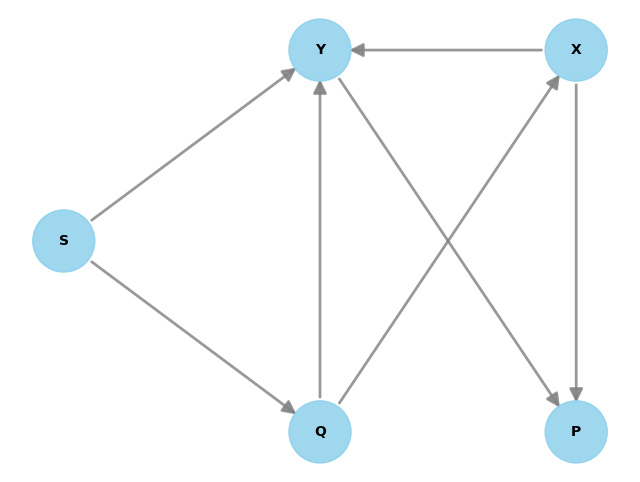

In [6]:
model.view_model()

## Paso 2 - El estimando

In [7]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Paso 3 - La estimación

In [8]:
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
        'model_y': GradientBoostingRegressor(),
        'model_t': GradientBoostingRegressor(),
        'model_final': LassoCV(fit_intercept=False),
        },
    'fit_params': {}}
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [9]:
print(f'Estimate of causal effect (DML): {estimate.value}')

Estimate of causal effect (DML): 0.6495806332790123


In [10]:
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')

Estimate of causal effect (linear regression): 0.6953815142698055


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


## Paso 4 - Refutaciones

In [11]:
random_cause = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause'
    )

print(random_cause)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Add a random common cause
Estimated effect:0.6495806332790123
New effect:0.6780347038226686
p value:0.10000000000000009



In [12]:
placebo_refuter = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

print(placebo_refuter)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Refute: Use a Placebo Treatment
Estimated effect:0.6495806332790123
New effect:0.0
p value:1.0



# EJEMPLO 2

**GCM API**

In [13]:
import networkx as nx
from dowhy import gcm

In [14]:
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']
graph_nx = nx.DiGraph([(edge[0],
edge[1]) for edge in edges])

In [16]:
# Plot the graph


In [17]:
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

In [18]:
causal_model.set_causal_mechanism('S', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('P', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Q', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

In [19]:
gcm.fit(causal_model, df)
gcm.arrow_strength(causal_model, 'Y')

Fitting causal mechanism of node P: 100%|██████████| 5/5 [00:00<00:00, 167.88it/s]


{('Q', 'Y'): 0.0005973937236239906,
 ('S', 'Y'): 0.009041438255681447,
 ('X', 'Y'): 0.007014155738714807}

In [20]:
gcm.counterfactual_samples(
    causal_model,
    {'X': lambda x: .21},
    observed_data=pd.DataFrame(data=dict(X=[.5],
                                         Y=[.75], S=[.5], Q=[.4], P=[.34])))

,S,Q,X,Y,P
0,0.5,0.4,0.21,0.543105,0.179979


# Ejemplo 3

**DAGitty**

In [21]:
df

,S,Q,X,Y,P
0,0.673218,0.694031,0.328804,0.683318,0.307086
1,0.819618,0.323839,0.443273,0.634301,0.415813
2,0.330125,0.217097,0.047765,0.167457,0.254503
3,0.452109,0.301286,0.292325,0.420057,0.252396
4,0.625071,0.130260,0.172122,0.474068,0.379701
...,...,...,...,...,...
995,0.610718,0.696450,0.124413,0.452109,0.278539
996,0.324186,0.513907,0.429729,0.517774,0.509999
997,0.087224,0.568038,0.334126,0.474871,0.453448
998,0.131813,0.297937,0.118844,0.228543,0.273913


In [22]:
# Fit an OLS model Y # X + Q
import statsmodels.api as sm

X = df[['X', 'Q']]
X = sm.add_constant(X)
y = df['Y']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     392.7
Date:                Tue, 04 Mar 2025   Prob (F-statistic):          1.69e-126
Time:                        17:38:05   Log-Likelihood:                 739.57
No. Observations:                1000   AIC:                            -1473.
Df Residuals:                     997   BIC:                            -1458.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2154      0.011     19.335      0.000       0.194       0.237
X              0.6954      0.032     21.797      0.000       0.633       0.758
Q              0.2524      0.019     13.578      0.000       0.216       0.289
==============================================================================
Omnibus:                       28.247   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.441
Skew:                           0.111   Prob(JB):                     0.000444
Kurtosis:                       2.433   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Refutaciones**

S ⊥ X | Q

In [24]:
X = df[['X', 'Q']]
X = sm.add_constant(X)
y = df['S']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     39.77
Date:                Tue, 04 Mar 2025   Prob (F-statistic):           2.42e-17
Time:                        17:42:34   Log-Likelihood:                -160.45
No. Observations:                1000   AIC:                             326.9
Df Residuals:                     997   BIC:                             341.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3305      0.027     12.063      0.000       0.277       0.384
X             -0.0559      0.078     -0.713      0.476      -0.210       0.098
Q              0.4059      0.046      8.879      0.000       0.316       0.496
==============================================================================
Omnibus:                      340.135   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.296
Skew:                           0.037   Prob(JB):                     1.97e-11
Kurtosis:                       1.915   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

S ⊥ P | X, Y

In [26]:
X = df[['X', 'P', 'Y']]
X = sm.add_constant(X)
y = df['S']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     629.9
Date:                Tue, 04 Mar 2025   Prob (F-statistic):          1.70e-229
Time:                        17:43:11   Log-Likelihood:                 333.08
No. Observations:                1000   AIC:                            -658.2
Df Residuals:                     996   BIC:                            -638.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1055      0.022     -4.850      0.000      -0.148      -0.063
X             -1.4016      0.068    -20.623      0.000      -1.535      -1.268
P              0.0082      0.088      0.093      0.926      -0.165       0.181
Y              1.8974      0.047     39.993      0.000       1.804       1.991
==============================================================================
Omnibus:                       17.817   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.565
Skew:                           0.057   Prob(JB):                      0.00508
Kurtosis:                       2.510   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Q ⊥ P | X, Y

In [27]:
X = df[['P', 'X', 'Y']]
X = sm.add_constant(X)
y = df['Q']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Q   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     73.56
Date:                Tue, 04 Mar 2025   Prob (F-statistic):           5.59e-43
Time:                        17:43:43   Log-Likelihood:                 291.53
No. Observations:                1000   AIC:                            -575.1
Df Residuals:                     996   BIC:                            -555.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1685      0.023      7.435      0.000       0.124       0.213
P             -0.0272      0.092     -0.296      0.767      -0.207       0.153
X             -0.1685      0.071     -2.378      0.018      -0.308      -0.029
Y              0.6241      0.049     12.618      0.000       0.527       0.721
==============================================================================
Omnibus:                      227.958   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.906
Skew:                          -0.035   Prob(JB):                     4.82e-10
Kurtosis:                       1.988   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""